# Proyecto 04

Te presentamos los pasos a seguir para realizar el proyecto 04.

1. Elige tu punto de partida entre dos opciones:
Tus Proyectos 01 y 02
Tu Proyecto 03
Si corresponde, emprolija lo hecho hasta el momento, incorporando las correcciones y/o sugerencias que hayas recibido de tu(s) evaluador/a (es/as).

2. Formula una nueva pregunta, problema o desafío para explorar. Aquí hay una lista no exhaustiva de opciones que puedes elegir:

3. Prueba un modelo de Machine Learning nuevo que no hayas visto en la carrera. En ese caso, debes explicar su funcionamiento y por qué consideras apropiado aplicarlo. La ganancia no necesariamente tiene que ser en desempeño, también puede ser en interpretabilidad o aplicabilidad.
4. Agrega al proyecto información de otra fuente. ¡Es sumamente válido! En ese caso, debe estar claramente explicado cómo conseguiste esos datos y qué usos esperas darles. Los datos deben ser accesibles por tu evaluador/a (por ejemplo, puedes subirlos al repositorio). Presta atención a la sensibilidad y privacidad de los datos antes de compartirlos.
5. Continúa el Análisis Exploratorio de Datos. Recuerda que es tan importante como entrenar un modelo de Machine Learning.
5. Sigue las sugerencias que te propusimos en los notebooks para continuar el Proyecto 03.

Plantea un objetivo alcanzable. En esta etapa de tu formación, es preferible un problema sencillo bien abordado que uno ambicioso que no sabes cómo abordar. El objetivo debe estar correctamente explicitado. Debes explicar qué quieres hacer y qué esperas encontrar. Imagina que es una tarea en tu trabajo y tienes que explicarle a un/a jefe/a qué vas a hacer y por qué.

### Punto de partida: Proyecto 03

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.plotting import autocorrelation_plot

import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model
import tensorflow
import torch
import torch.nn as nn
from tensorflow.keras.layers import Dense, Activation, Flatten

tensorflow.random.set_seed(2)

pd.set_option('display.max_columns', 500)

#### Funciones

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def graficas_modelo(ytest,ytestpred,ytrain,ytrainpred):
    
    sns.set()
    gs = gridspec.GridSpec(4, 4)

    plt.figure(figsize=(17.5,20))

    ax = plt.subplot(gs[0,2]) # row 0, col 0
    plt.scatter(ytestpred,ytest,color='orange')
    plt.plot([ ytestpred.min(),  ytestpred.max()], [ ytestpred.min(), ytestpred.max()],
                        'k--', color = 'black', lw=2)
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.grid(True)

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    sns.distplot(ytest- ytestpred,color= "orange")

    plt.title('Distribución residuos del modelo en test',fontweight = "bold")
    plt.xlabel("Residuo")

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    plt.scatter(list(range(len(ytest))), ytest -  ytestpred,
                           edgecolors=(0, 0, 0), alpha = 0.4)
    plt.title("Diagrama de residuos en test",fontweight = "bold")
    plt.xlabel('Valores')
    

    ax = plt.subplot(gs[2, 1]) # row 2, col 0
    plt.scatter(ytrainpred,ytrain,color='green')
    plt.plot([ ytrainpred.min(),  ytrainpred.max()], [ ytrainpred.min(), ytrainpred.max()],
                        'k--', color = 'black', lw=2)
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.grid(True)

    ax = plt.subplot(gs[2, 2]) # row 2, col 1
    sns.distplot(ytrain-ytrainpred,color= "green")

    plt.title('Distribución residuos del modelo en train',fontweight = "bold")
    plt.xlabel("Residuo")

    ax = plt.subplot(gs[3, :]) # row 1, span all columns
    plt.scatter(list(range(len(ytrain))), ytrain -  ytrainpred,
                           edgecolors=(0, 0, 0), alpha = 0.4)
    plt.title("Diagrama de residuos en entrenamiento",fontweight = "bold")
    plt.xlabel('Valores')


    plt.show()

In [4]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=14).mean()
    rolstd = timeseries.rolling(window=14).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Main

In [5]:
data_2013=pd.read_csv('./Datasets/flujo-vehicular-2013.csv',sep=',')
data_2014=pd.read_csv('./Datasets/flujo-vehicular-2014.csv',sep=',')
data_2015=pd.read_csv('./Datasets/flujo-vehicular-2015.csv',sep=',')
data_2016=pd.read_csv('./Datasets/flujo-vehicular-2016.csv',sep=',')
data_2019=pd.read_csv('./Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018=pd.read_csv('./Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017=pd.read_csv('./Datasets/flujo-vehicular-2017.csv', sep =',')



In [6]:
#Datasets 2013 a 2015

data_2013.head(20)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2013,2013-01-01,0,Martes,Alberdi,Liviano,NO COBRADO,20
1,2013,2013-01-01,0,Martes,Alberdi,Liviano,EFECTIVO,1
2,2013,2013-01-01,0,Martes,Alberdi,Liviano,EFECTIVO,51
3,2013,2013-01-01,0,Martes,Alberdi,Liviano,AUPASS,16
4,2013,2013-01-01,1,Martes,Alberdi,Liviano,NO COBRADO,1
5,2013,2013-01-01,1,Martes,Alberdi,Liviano,EXENTO,1
6,2013,2013-01-01,1,Martes,Alberdi,Liviano,EFECTIVO,5
7,2013,2013-01-01,1,Martes,Alberdi,Liviano,EXENTO,4
8,2013,2013-01-01,1,Martes,Alberdi,Liviano,EFECTIVO,351
9,2013,2013-01-01,1,Martes,Alberdi,Liviano,TARJETA DISCAPACIDAD,6


In [7]:
data_2013.estacion.value_counts()

Avellaneda            226150
Dellepiane Liniers    202655
Illia                 187252
Alberdi                90344
Name: estacion, dtype: int64

In [8]:
data_2013.forma_pago.value_counts()

EFECTIVO                215282
AUPASS                  183444
EXENTO                   96496
INFRACCION               69780
NO COBRADO               65181
TARJETA DISCAPACIDAD     57029
MONEDERO                 19189
Name: forma_pago, dtype: int64

In [9]:
data_2014.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2014.0,2014-01-01,0.0,Miercoles,Alberdi,Liviano,NO COBRADO,26.0
1,2014.0,2014-01-01,0.0,Miercoles,Alberdi,Liviano,EFECTIVO,2.0


In [10]:
data_2014.estacion.value_counts()

Avellaneda            226196
Dellepiane Liniers    200461
Illia                 197050
Alberdi                91227
Retiro                 85096
Sarmiento               9344
Name: estacion, dtype: int64

In [11]:
data_2014.forma_pago.value_counts()

EFECTIVO                249885
AUPASS                  207094
EXENTO                  110986
INFRACCION               79444
NO COBRADO               72967
TARJETA DISCAPACIDAD     64087
MONEDERO                 24911
Name: forma_pago, dtype: int64

In [12]:
data_2015.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2015,2015-01-01,0,Jueves,Alberdi,Liviano,NO COBRADO,15
1,2015,2015-01-01,0,Jueves,Alberdi,Liviano,EFECTIVO,1


In [13]:
data_2015.forma_pago.value_counts()

EFECTIVO                314209
AUPASS                  284746
EXENTO                  126277
INFRACCION              110161
NO COBRADO               87620
TARJETA DISCAPACIDAD     68947
MONEDERO                 25998
Name: forma_pago, dtype: int64

In [14]:
data_2015.estacion.value_counts()

Avellaneda            227752
Illia                 193194
Dellepiane Liniers    180813
Dellepiane Centro     151764
Retiro                142994
Alberdi                87930
Sarmiento              22997
Salguero               10514
Name: estacion, dtype: int64

Para estos vehículos no se ha considerado la variable "sentido". Por este motivo solamente consideraré los datos de 2016 a 2019:

In [15]:
#Datasets 2016 a 2019

data_2016_2019 = pd.concat([data_2019, data_2018, data_2017, data_2016])

data_2016_2019.head(2)

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6


In [16]:
data_2016_2019 = pd.concat([data_2019, data_2018, data_2017, data_2016])

mask = np.logical_and(data_2016_2019.estacion=='Illia', data_2016_2019.forma_pago == 'EFECTIVO')
dataset_2016_2019 = data_2016_2019[mask]
dataset_2016_2019.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769


In [17]:
dataset_2016_2019['fecha2']=pd.to_datetime(dataset_2016_2019.fecha)#+ pd.to_timedelta(dataset_2016_2019.hora_fin.astype(int),unit='hours')
dataset_2016_2019.head()

<ipython-input-17-879efcda9b0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2016_2019['fecha2']=pd.to_datetime(dataset_2016_2019.fecha)#+ pd.to_timedelta(dataset_2016_2019.hora_fin.astype(int),unit='hours')


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537,2019-01-01
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1,2019-01-01
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443,2019-01-01
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-01-01
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769,2019-01-01


In [18]:
dataset_2016_2019.drop(['periodo','fecha','hora_inicio','hora_fin','estacion','forma_pago'],axis=1,inplace=True)
dataset_2016_2019.head()

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01
86,Martes,Centro,Pesado,1,2019-01-01
88,Martes,Provincia,Liviano,443,2019-01-01
94,Martes,Provincia,Pesado,1,2019-01-01
149,Martes,Centro,Liviano,769,2019-01-01


In [19]:
dataset_2016_2019.sort_values('fecha2', inplace = True)
dataset_2016_2019.reset_index(drop=True, inplace = True)

<ipython-input-19-e3e917edde83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2016_2019.sort_values('fecha2', inplace = True)


In [20]:
tipo_vehiculo = dataset_2016_2019.groupby("fecha2")["tipo_vehiculo"].agg(lambda x: scipy.stats.mode(x)[0][0])
sentido= dataset_2016_2019.groupby("fecha2")["sentido"].agg(lambda x: scipy.stats.mode(x)[0][0])
dataset_2016_2019=dataset_2016_2019.resample('D',on='fecha2').sum()

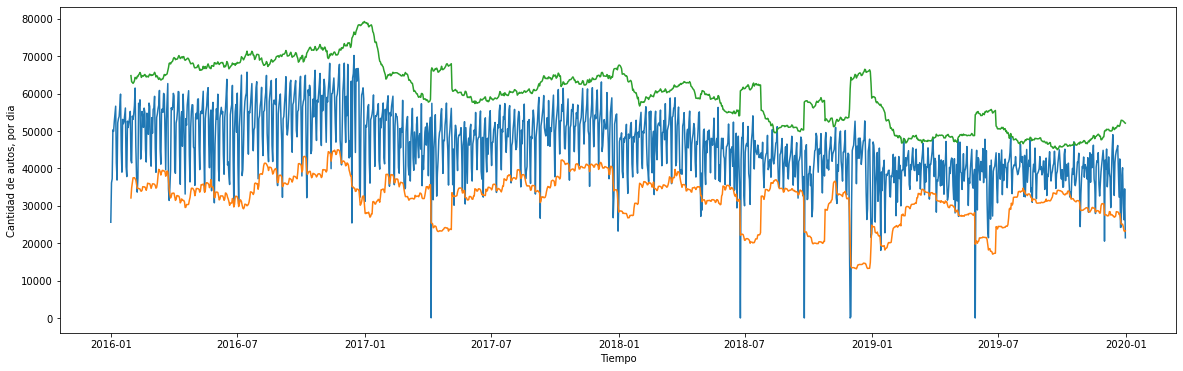

In [21]:
#Defino una ventana de 30 días

wind =30
sigma = 2

dataset_2016_2019["inferior"] = dataset_2016_2019.cantidad_pasos.rolling(window=wind)\
    .mean() - (sigma * dataset_2016_2019.cantidad_pasos.rolling(window=wind).std())
dataset_2016_2019["superior"] = dataset_2016_2019.cantidad_pasos.rolling(window=wind)\
    .mean() + (sigma * dataset_2016_2019.cantidad_pasos.rolling(window=wind).std())

dataset_2016_2019['anom']=dataset_2016_2019.apply(lambda x: x['cantidad_pasos'] if (x['cantidad_pasos'] <= x['inferior'] or x['cantidad_pasos']>=x['superior'] ) else 0,axis=1)

plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.inferior)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.superior)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

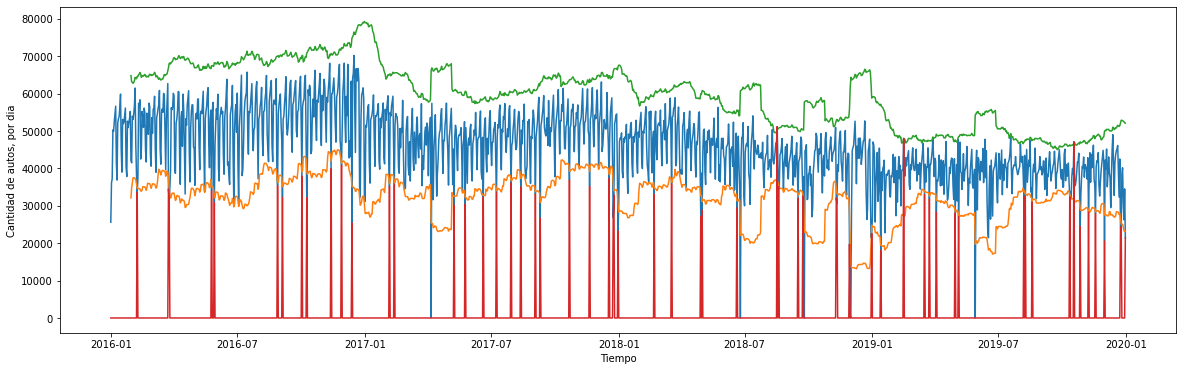

In [22]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.inferior)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.superior)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.anom)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [23]:
dataset_2016_2019.cantidad_pasos=dataset_2016_2019.apply(lambda x: x['cantidad_pasos'] if (x['anom']==0) else np.nan,axis=1)
dataset_2016_2019.cantidad_pasos=dataset_2016_2019.cantidad_pasos.replace(0,np.nan)
dataset_2016_2019.loc[dataset_2016_2019.anom!=0]

,cantidad_pasos,inferior,superior,anom
fecha2,,,,
2016-02-08,NaN,34635.947653,64624.119013,33661.0
2016-03-24,NaN,36906.949232,66936.784102,34499.0
2016-03-25,NaN,34573.020120,68090.246546,31431.0
2016-05-25,NaN,35063.819494,67475.713840,34024.0
2016-05-29,NaN,32161.136691,68258.863309,30796.0
...,...,...,...,...
2019-11-18,NaN,28343.912500,48437.754167,27937.0
2019-12-01,NaN,27530.375633,49940.291033,20553.0
2019-12-24,NaN,26616.516603,52186.016730,24220.0


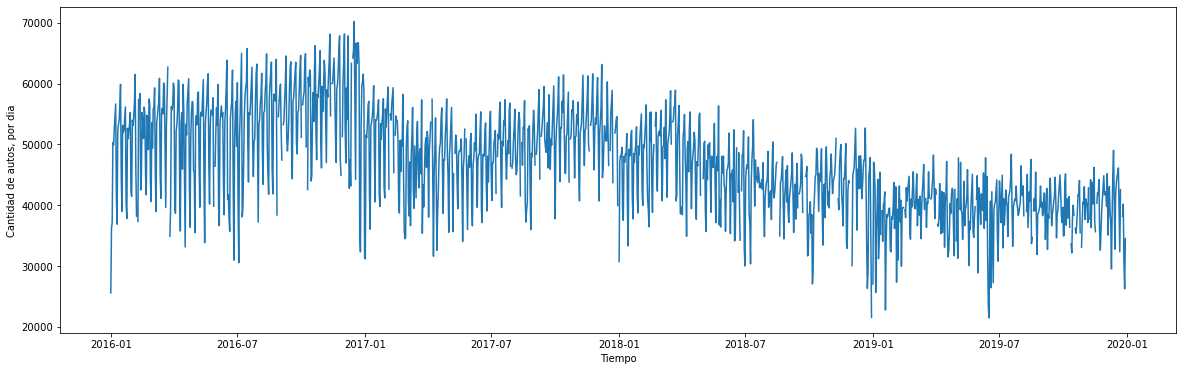

In [24]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [25]:
dataset_2016_2019.drop(['inferior','superior','anom'],axis=1,inplace=True)

print("El dataset tiene los siguientes valores nulos:")
dataset_2016_2019.isnull().sum()

El dataset tiene los siguientes valores nulos:


cantidad_pasos    66
dtype: int64

In [26]:
dataset_2016_2019 =dataset_2016_2019.interpolate()

print("El dataset de diario tiene los siguientes valores nulos:")
dataset_2016_2019.isnull().sum()

El dataset de diario tiene los siguientes valores nulos:


cantidad_pasos    0
dtype: int64

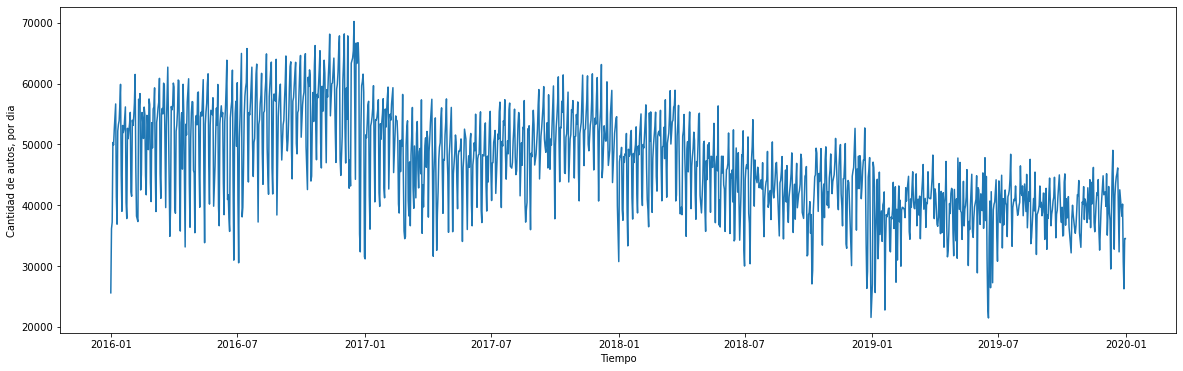

In [27]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [28]:
dataset_2016_2019['tipo_vehiculo']=tipo_vehiculo
dataset_2016_2019['sentido']=sentido

dataset_2016_2019.head()

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2016-01-01,25602.0,Pesado,Centro
2016-01-02,36136.0,Pesado,Centro
2016-01-03,37225.0,Pesado,Centro
2016-01-04,50312.0,Pesado,Centro
2016-01-05,49907.0,Pesado,Centro


In [29]:
dataset_2016_2019.isnull().sum()

cantidad_pasos    0
tipo_vehiculo     4
sentido           4
dtype: int64

Como se puede observar, sigo teniendo los siguientes valores nulos:

In [30]:
dataset_2016_2019[dataset_2016_2019.tipo_vehiculo.isnull()==True]

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-25,38312.5,NaN,NaN
2018-09-25,41299.5,NaN,NaN
2018-11-30,36899.5,NaN,NaN
2019-05-29,40353.5,NaN,NaN


In [31]:
dataset_2016_2019[dataset_2016_2019.sentido.isnull()==True]

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-25,38312.5,NaN,NaN
2018-09-25,41299.5,NaN,NaN
2018-11-30,36899.5,NaN,NaN
2019-05-29,40353.5,NaN,NaN


Voy a utilizar el metodo pad de fillna para reemplazar los valores nulos con el valor del día anterior

In [32]:
dataset_2016_2019.loc[dataset_2016_2019.index == '2018-06-24']

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-24,34255.0,Pesado,Centro


In [33]:
dataset_2016_2019['tipo_vehiculo'].fillna(method='pad', inplace=True)
dataset_2016_2019['sentido'].fillna(method='pad', inplace=True)

In [34]:
dataset_2016_2019.loc[dataset_2016_2019.index == '2018-06-25']

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-25,38312.5,Pesado,Centro


In [35]:
dataset_2016_2019.sentido.isnull().sum()

0

Transformación de variables categóricas en numéricas

In [36]:
dataset_2016_2019.tipo_vehiculo.value_counts()

Pesado     1094
Liviano     367
Name: tipo_vehiculo, dtype: int64

In [37]:
dataset_2016_2019.tipo_vehiculo=np.where(dataset_2016_2019.tipo_vehiculo=='Pesado',0,1)

In [38]:
dataset_2016_2019.sentido.value_counts()

Centro       1348
Provincia     113
Name: sentido, dtype: int64

In [39]:
dataset_2016_2019.sentido=np.where(dataset_2016_2019.sentido=='Centro',0,1)

#### Armado de datasets de entrenamiento y testeo con la variable cantidad_pasos

In [40]:
senial=pd.DataFrame(dataset_2016_2019.cantidad_pasos)
values = senial.values
data_single = series_to_supervised(values, 28, 1)
pd.DataFrame(data_single)

,var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
28,25602.0,36136.0,37225.0,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,56429.0,59870.0,44985.0,38999.0,53109.0,51946.0,52463.0,54254.0,56158.000000,40479.000000,37808.000000,52645.000000,50942.000000,52301.000000,53411.0,55258.0
29,36136.0,37225.0,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,56429.0,59870.0,44985.0,38999.0,53109.0,51946.0,52463.0,54254.0,56158.0,40479.000000,37808.000000,52645.000000,50942.000000,52301.000000,53411.000000,55258.0,42187.0
30,37225.0,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,56429.0,59870.0,44985.0,38999.0,53109.0,51946.0,52463.0,54254.0,56158.0,40479.0,37808.000000,52645.000000,50942.000000,52301.000000,53411.000000,55258.000000,42187.0,41477.0
31,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,56429.0,59870.0,44985.0,38999.0,53109.0,51946.0,52463.0,54254.0,56158.0,40479.0,37808.0,52645.000000,50942.000000,52301.000000,53411.000000,55258.000000,42187.000000,41477.0,53972.0
32,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,56429.0,59870.0,44985.0,38999.0,53109.0,51946.0,52463.0,54254.0,56158.0,40479.0,37808.0,52645.0,50942.000000,52301.000000,53411.000000,55258.000000,42187.000000,41477.000000,53972.0,53116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,44841.0,41722.0,41968.5,42215.0,39820.0,45181.0,35084.0,38676.0,43076.0,38839.0,37518.0,29518.0,38546.0,45099.0,49027.0,40478.0,32774.0,41588.0,43597.0,44687.0,45241.0,46128.000000,39303.000000,32337.000000,42531.000000,41076.666667,39622.333333,38168.0,40182.0
1457,41722.0,41968.5,42215.0,39820.0,45181.0,35084.0,38676.0,43076.0,38839.0,37518.0,29518.0,38546.0,45099.0,49027.0,40478.0,32774.0,41588.0,43597.0,44687.0,45241.0,46128.0,39303.000000,32337.000000,42531.000000,41076.666667,39622.333333,38168.000000,40182.0,30681.0
1458,41968.5,42215.0,39820.0,45181.0,35084.0,38676.0,43076.0,38839.0,37518.0,29518.0,38546.0,45099.0,49027.0,40478.0,32774.0,41588.0,43597.0,44687.0,45241.0,46128.0,39303.0,32337.000000,42531.000000,41076.666667,39622.333333,38168.000000,40182.000000,30681.0,26259.0
1459,42215.0,39820.0,45181.0,35084.0,38676.0,43076.0,38839.0,37518.0,29518.0,38546.0,45099.0,49027.0,40478.0,32774.0,41588.0,43597.0,44687.0,45241.0,46128.0,39303.0,32337.0,42531.000000,41076.666667,39622.333333,38168.000000,40182.000000,30681.000000,26259.0,34523.0


In [41]:
senial=dataset_2016_2019.cantidad_pasos

look_back=7*4

N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back)) #Voy a generar los arrays para X e Y.
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1432, 28) (1432,)


In [42]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]
    
print(X)

print(y)

[[25602.         36136.         37225.         ... 50942.
  52301.         53411.        ]
 [36136.         37225.         50312.         ... 52301.
  53411.         55258.        ]
 [37225.         50312.         49907.         ... 53411.
  55258.         42187.        ]
 ...
 [41722.         41968.5        42215.         ... 39622.33333333
  38168.         40182.        ]
 [41968.5        42215.         39820.         ... 38168.
  40182.         30681.        ]
 [42215.         39820.         45181.         ... 40182.
  30681.         26259.        ]]
[55258. 42187. 41477. ... 30681. 26259. 34523.]


In [43]:
N_train = 365*3+270- look_back # cantidad de instancias que vamos a usar para entrenar.
N_test = 90 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train_single = X[:N_train,:]
y_train_single = y[:N_train]
print(X_train_single.shape, y_train_single.shape)

X_test_single = X[N_train:N_train+N_test,:]
y_test_single = y[N_train:N_train+N_test]
print(X_test_single.shape, y_test_single.shape)

(1337, 28) (1337,)
(90, 28) (90,)


#### Armado de los datasets de entrenamiento y testeo con las variables cantidad_pasos, sentido y tipo vehiculo

Como se vío en el Proyecto 03, con datos de series temporales, la secuencia de valores es importante. Voy a aplicar el mismo método de one step prediction, pero en este caso no es tan secillo porque no tengo una sola variable, sino 3, es decir, estoy en un caso de análisis de series temporales multivariado. Para transformar el dataset en un problema de análisis supervisado tengo que considerar  el valor de cantidad_pasos en t y debería poder considerar también las 4 variables para cada uno de los 28 días anteriores, lo cual me da 3x28 columnas. Esto se lleva a cabo por medio de la función series_to_supervised. Considero nuevamente un lookback de 28 días.

In [44]:
ds=dataset_2016_2019
values = ds.values
data = series_to_supervised(values, 28, 1)
pd.DataFrame(data)

,var1(t-28),var2(t-28),var3(t-28),var1(t-27),var2(t-27),var3(t-27),var1(t-26),var2(t-26),var3(t-26),var1(t-25),var2(t-25),var3(t-25),var1(t-24),var2(t-24),var3(t-24),var1(t-23),var2(t-23),var3(t-23),var1(t-22),var2(t-22),var3(t-22),var1(t-21),var2(t-21),var3(t-21),var1(t-20),var2(t-20),var3(t-20),var1(t-19),var2(t-19),var3(t-19),var1(t-18),var2(t-18),var3(t-18),var1(t-17),var2(t-17),var3(t-17),var1(t-16),var2(t-16),var3(t-16),var1(t-15),var2(t-15),var3(t-15),var1(t-14),var2(t-14),var3(t-14),var1(t-13),var2(t-13),var3(t-13),var1(t-12),var2(t-12),var3(t-12),var1(t-11),var2(t-11),var3(t-11),var1(t-10),var2(t-10),var3(t-10),var1(t-9),var2(t-9),var3(t-9),var1(t-8),var2(t-8),var3(t-8),var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
28,25602.0,0.0,0.0,36136.0,0.0,0.0,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.000000,0.0,0.0,40479.000000,0.0,0.0,37808.000000,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.0,0.0,0.0,55258.0,0.0,0.0
29,36136.0,0.0,0.0,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.000000,0.0,0.0,37808.000000,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.0,0.0,0.0,42187.0,0.0,0.0
30,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.000000,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.000000,0.0,0.0,42187.0,0.0,0.0,41477.0,0.0,0.0
31,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.000000,0.0,0.0,42187.000000,0.0,0.0,41477.0,0.0,0.0,53972.0,0.0,0.0
32,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.000000,0.0,0.0,42187.000000,0.0,0.0,41477.000000,0.0,0.0,53972.0,0.0,0.0,53116.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,44841.0,1.0,0.0,41722.0,1.0,0.0,41968.5,1.0,1.0,42215.0,1.0,0.0,39820.0,1.0,0.0,45181.0,1.0,0.0,35084.0,1.0,0.0,38676.0,1.0,0.0,43076.0,1.0,0.0,38839.0,1.0,0.0,37518.0,1.0,0.0,29518.0,1.0,0.0,38546.0,1.0,0.0,45099.0,1.0,0.0,49027.0,1.0,

Como dije anteriormente, voy a predecir los valores en el tiempo t utilizando un look back de 28 días. Mi variable objetivo es la cantidad de pasos.

In [45]:
X=data.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
y=data[['var1(t)']]

X_columns=X.columns

X=X.values
y=y.values

In [46]:
look_back=7*4

N_train = 365*3+270- look_back # 3 años + 3 trimestres
N_test = 90 # 1 trimestre
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(1337, 84) (1337, 1)
(90, 84) (90, 1)


### Modelos autorregresivos

Voy a utilizar un método autorregresivo para utilizarlo en mis predicciones.

In [47]:
senial

fecha2
2016-01-01    25602.0
2016-01-02    36136.0
2016-01-03    37225.0
2016-01-04    50312.0
2016-01-05    49907.0
               ...   
2019-12-27    40182.0
2019-12-28    30681.0
2019-12-29    26259.0
2019-12-30    34523.0
2019-12-31    34523.0
Freq: D, Name: cantidad_pasos, Length: 1461, dtype: float64

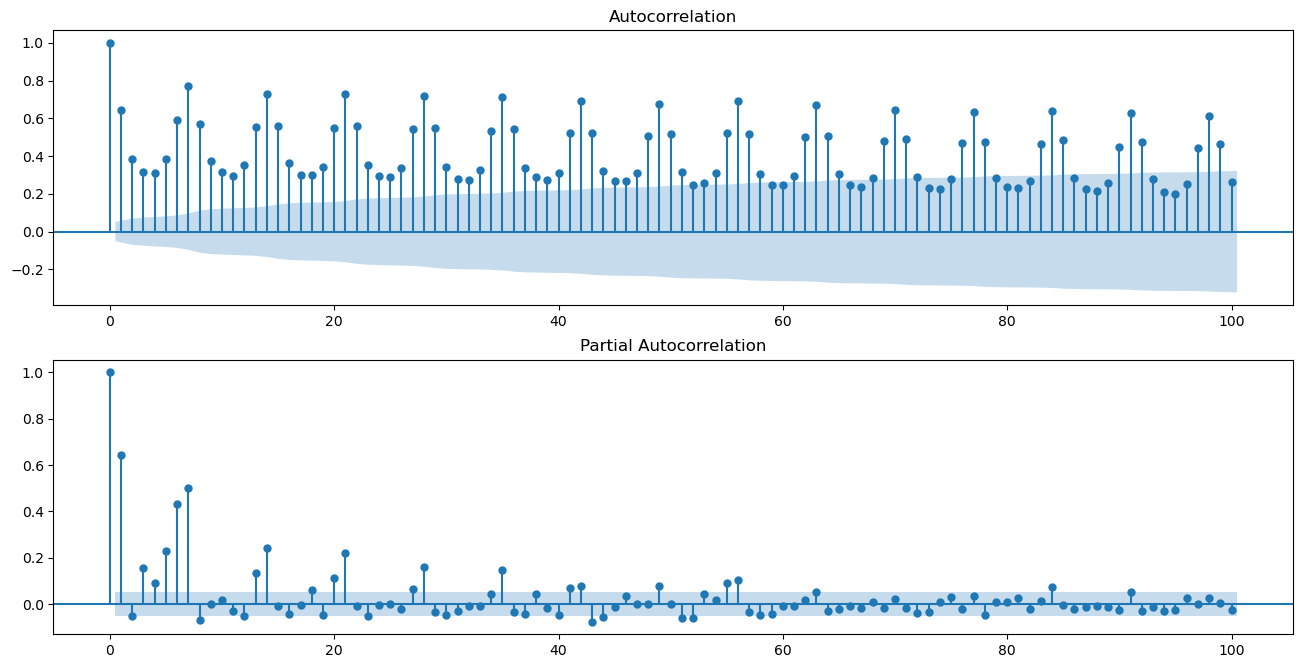

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,figsize=(16,8), dpi= 100)
plot_acf(senial, lags=100, ax=axes[0])
plot_pacf(senial, lags=100, ax=axes[1])
plt.show()

La autocorrelación utiliza la correlación de Pearson para ver la correlación de la serie con días anteriores, teniendo en cuenta relaciones directas e indirectas. La primera línea vale uno porque es con el mismo día. Luego observamos claramente como se preserva la estacionalidad, la presencia de un patrón de variación entre una semana y otra.

En la autocorrelación parcial, en la cual se quitan las relaciones indirectas, vemos como el flujo de un día de la semana va a depender del flujo del mismo día de la semana anterior y así sucesivamente. La misma va disminuyendo.

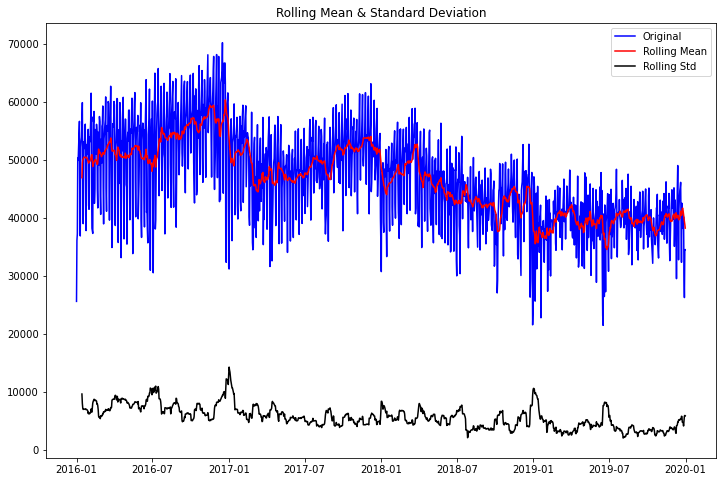

Results of Dickey-Fuller Test:
Test Statistic                   -1.349395
p-value                           0.606282
#Lags Used                       20.000000
Number of Observations Used    1440.000000
Critical Value (1%)              -3.434899
Critical Value (5%)              -2.863549
Critical Value (10%)             -2.567840
dtype: float64


In [49]:
resultado=test_stationarity(senial)

Si un proceso es estacionario, eso significa que no cambia sus propiedades estadísticas con el tiempo, es decir, su media y varianza.

Al comparar el estadístico ADF con los valores críticos, vemos que estos últimos son mas negativos, lo cual nos habla que la serie no es estacionaria. Esto a su vez se confirma con el valor del p-value (nos indica la fuerza con la que se rechaza la H0), que es mayor a 0.05, por lo cual no se rechaza la hipotesis nula, indicando con un 95% de probabilidad que la serie no es estacionaria.

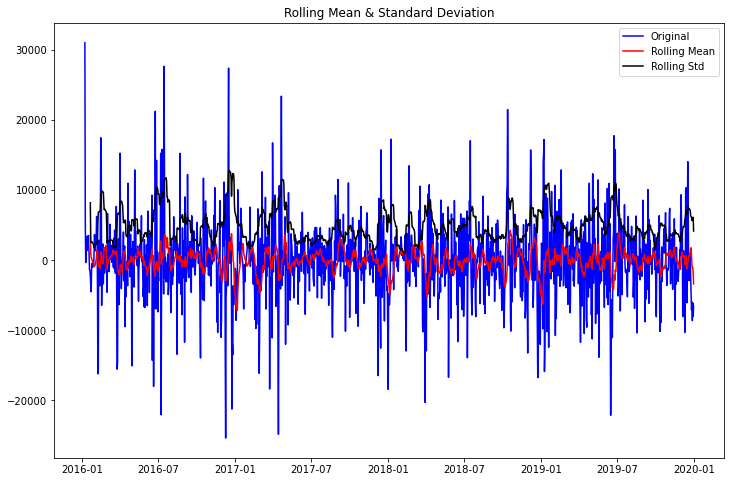

Results of Dickey-Fuller Test:
Test Statistic                -9.708183e+00
p-value                        1.028386e-16
#Lags Used                     2.300000e+01
Number of Observations Used    1.430000e+03
Critical Value (1%)           -3.434931e+00
Critical Value (5%)           -2.863563e+00
Critical Value (10%)          -2.567847e+00
dtype: float64


In [50]:
senial_estacionaria=senial-senial.shift(7)
senial_estacionaria.dropna(inplace=True)
resultado=test_stationarity(senial_estacionaria)

La prueba de Dickey Fuller muestra que la serie ahora es estacionaria. Esto también se puede comprobar con los gráficos de autocorrelación y autocorrelación parcial.

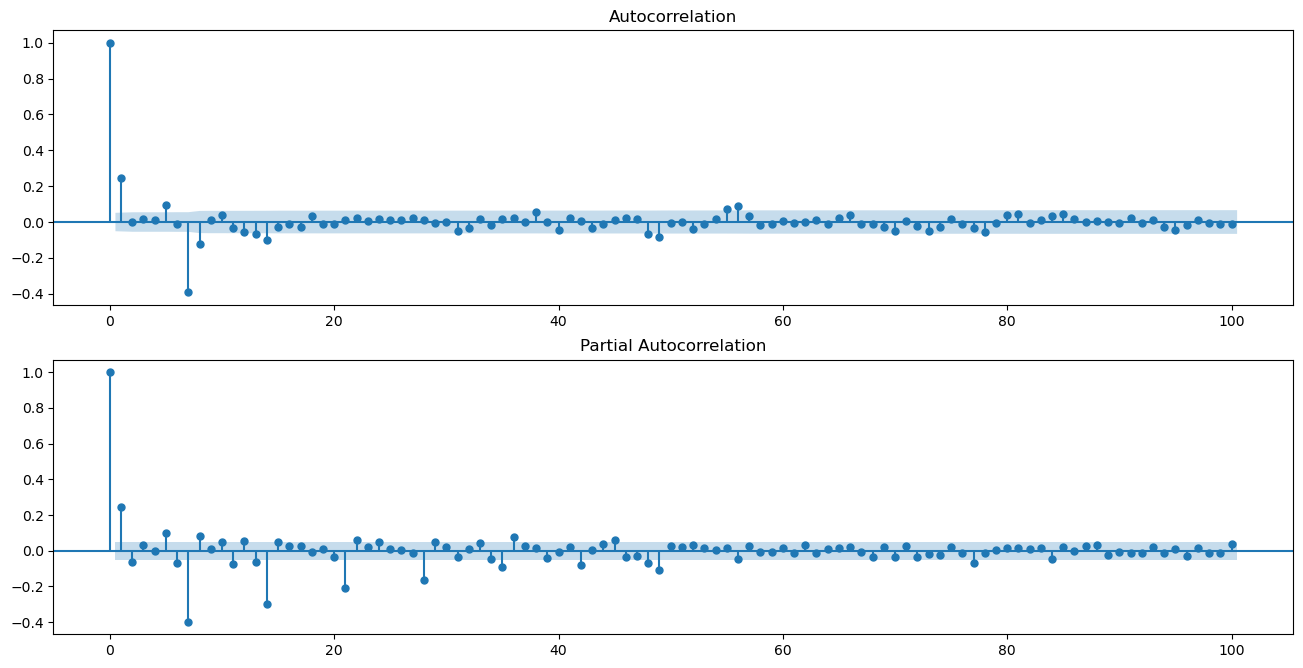

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,figsize=(16,8), dpi= 100)
plot_acf(senial_estacionaria, lags=100, ax=axes[0])
plot_pacf(senial_estacionaria, lags=100, ax=axes[1])
plt.show()

SARIMA (p, d, q) (P, D, Q, s) es un modelo de media móvil de autorregresión estacional donde:

AR (p): modelo de autorregresión, es decir, regresión de la serie de tiempo sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún rezago (o varios rezagos). El retraso máximo en el modelo se denomina p. Para determinar la p inicial, debe observar el gráfico PACF y encontrar el mayor retraso significativo después del cual la mayoría de los demás retrasos se vuelven insignificantes.

MA (q): modelo de media móvil. Sin entrar en demasiados detalles, modela el error de la serie temporal, nuevamente con el supuesto de que el error actual depende del anterior con cierto rezago, lo que se denomina q. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes. Combinemos nuestras primeras 4 letras:

AR (p) + MA (q) = ARMA (p, q) Lo que tenemos aquí es el modelo de media móvil autorregresiva. Si la serie es estacionaria, se puede aproximar con estas 4 letras. Continuemos.

I (d) : orden de integración. Este es simplemente el número de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos primeras diferencias. La adición de esta letra a las cuatro nos da el modelo ARIMA que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales.

S (s): esto es responsable de la estacionalidad e iguala la duración del período de temporada de la serie Con esto, tenemos tres parámetros: (P, D, Q) P - orden de autorregresión para el componente estacional del modelo, que puede derivarse de PACF. Pero debe observar la cantidad de retrasos significativos, que son los múltiplos de la duración del período de la temporada. Por ejemplo, si el período es igual a 7 y vemos que los rezagos 7 y 14 son significativos en el PACF, eso significa que la P inicial debería ser 2.

Q - lógica similar usando la gráfica ACF en su lugar.

D - orden de integración estacional. Esto puede ser igual a 1 o 0, dependiendo de si se aplicaron o no diferencias estacionales.

Ahora que sabemos cómo establecer los parámetros iniciales, echemos un vistazo al gráfico final una vez más y establezcamos los parámetros:

Se puede ver que ACT y PACT tienen un patrón cada 7 días, indicando que existe un patrón por semana. Hay un componente estacional fuerte por lo cual deberíamos usar SARIMA para tenerlo en cuenta.

p: es probable sea 7 ya que es el último rezago significativo en el PACF, después del cual, la mayoría de los demás no son significativos.

d: es igual a 1 porqye ya se ha diferenciado la serie previamente.

q:aproximadamente 7,  se ve en el ACF.

P: podría ser 2, ya que los retrasos 7 y 14 son algo significativos en el PACF.

D: nuevamente es igual a 1 porque realizamos la diferenciación estacional.

Q: es probablemente 1. El desfase 7 en ACF es significativo, mientras que el 14 no lo es.

In [52]:
N_train_sarima = 365*3+274 # cantidad de instancias que vamos a usar para entrenar.
N_test_sarima = 90 #cantidad de puntos que vamos a usar para evaluar

senial_train = senial[:N_train_sarima]
senial_test = senial[N_train_sarima:N_train_sarima+N_test_sarima]

In [53]:
senial_test

fecha2
2019-10-01    39669.000000
2019-10-02    34943.000000
2019-10-03    35054.000000
2019-10-04    43775.000000
2019-10-05    45150.000000
                  ...     
2019-12-25    39622.333333
2019-12-26    38168.000000
2019-12-27    40182.000000
2019-12-28    30681.000000
2019-12-29    26259.000000
Freq: D, Name: cantidad_pasos, Length: 90, dtype: float64

In [54]:
model=SARIMAX(senial_train,order=(5,1,1), seasonal_order=(1,1,0,7)).fit()

In [55]:
forecast=model.forecast(90)

In [56]:
forecast

2019-10-01    39097.084729
2019-10-02    41412.411128
2019-10-03    42452.265454
2019-10-04    45303.075388
2019-10-05    41480.941617
                  ...     
2019-12-25    41454.623216
2019-12-26    42633.778884
2019-12-27    45180.390495
2019-12-28    41585.138014
2019-12-29    37230.568574
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

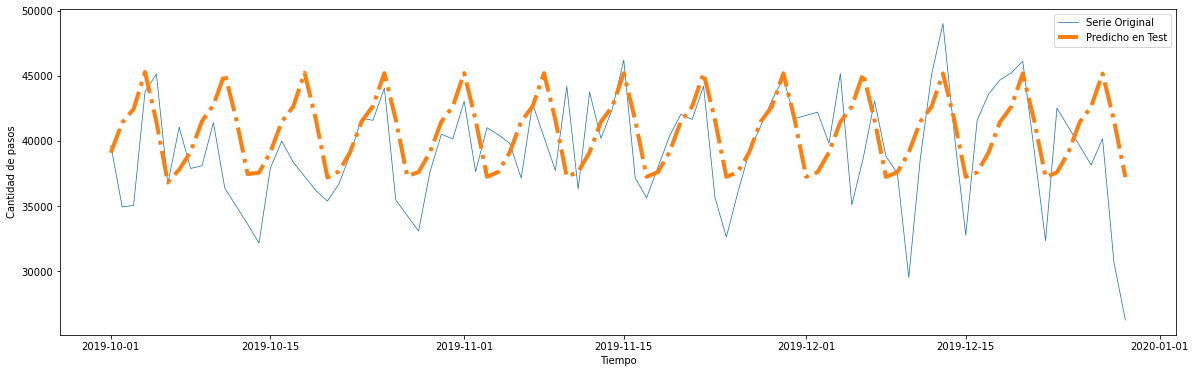

In [57]:
%matplotlib inline

plt.figure(figsize=(20,6))
plt.plot(senial.index[N_train_sarima:N_train_sarima+N_test_sarima], senial[N_train_sarima:N_train_sarima+N_test_sarima],lw = 0.75, label = 'Serie Original')
#plt.plot(senial.index[:N_train], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(senial.index[N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train_sarima:N_train_sarima+N_test_sarima], forecast,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [58]:
RMSE_test=np.sqrt(mean_squared_error(senial_test,forecast))
print("RMSE test single: :{:.2f}".format(RMSE_test))
r2_score_test=r2_score(senial_test,forecast)
print("R2 score test single: {:.2f}".format(r2_score_test))

RMSE test single: :4038.42
R2 score test single: 0.03


El modelo no es el más adecuado, debido a que se obtuvieron mejores métricas al aplicar un modelo de aprendizaje supervisado.

#### Modelo con Redes Neuronales N1

Vamos a configurar y entrenar una red neuronal básica utilizando solo variable cantidad_pasos

Es necesario hacer un preprocesado de los datos antes de someterlos a una Red Neuronal, teniendo en cuenta la variabilidad en la cantidad de pasos. 

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


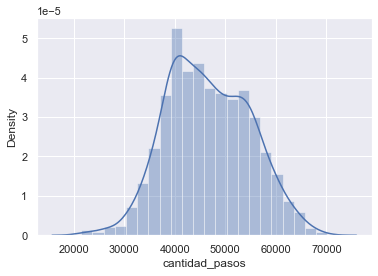

In [59]:
sns.set()
sns.distplot(dataset_2016_2019.cantidad_pasos)
plt.show()

Como vemos en el gráfico de distribución, existen diferencias notables en el número de pasos, por lo cual deberíamos aplicar un escalamiento de los datos. La distribución no es normal y no existen datos extremos que la afecten, por lo cual utilizaré MinMaxScaler.


Con el fin de evitar que la información sobre la distribución del conjunto de test se filtre en el modelo, se debe ajustar el escalador solo en los datos de entrenamiento, luego estandarizar los conjuntos de entrenamiento y de prueba con ese escalador. Al ajustar el escalador en el conjunto de datos completo antes de dividirlo la información sobre el conjunto de test se usa para transformar el conjunto de entrenamiento.

In [60]:
senial=pd.DataFrame(dataset_2016_2019.cantidad_pasos)

look_back=28

N_train = 365*3+270- look_back # 3 años + 3 trimestres
N_test = 90 # 1 trimestre
N_total = N_train + N_test

train_data = senial[:N_train]
test_data = senial[-N_test:]

print("Train data : {} - Test data: {}".format(train_data.shape,test_data.shape))

Train data : (1337, 1) - Test data: (90, 1)


Para obtener el dataset de testeo, obtendré las últimas 28 observaciones del dataset de entrenamiento y las agregaré al dataset de testeo. Esto es importante a la hora de transformar el problema de series temporales en análisis supervisado, ya que se utilizarán los 28 días anteriores para predecir el 29, que es donde comienza en este caso el dataset de testeo.

In [61]:
test_data= pd.concat([train_data[-look_back:],test_data],axis=0)

Vamos a entrenar y transformar el escalador con el conjunto de entrenamiento y transformar el de testeo. Esto es para evitar que información del dataset de entrenamiento genere un sesgo en el de testeo

In [62]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled=scaler.fit_transform(test_data.values.reshape(-1, 1))

Como se vío en el Proyecto 03, con datos de series temporales, la secuencia de valores es importante. 

Voy a aplicar el mismo método de one step prediction, considerando nuevamente un lookback de 28 días. Tendré entonces un total de 28 columnas

In [63]:
train_reframed = series_to_supervised(train_scaled , look_back, 1)
test_reframed = series_to_supervised(test_scaled , look_back, 1)

In [64]:
train_reframed.head(2)

,var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
28,-0.830385,-0.398079,-0.353388,0.183691,0.167070,0.273156,0.356137,0.443592,-0.180039,-0.367464,0.260598,0.306111,0.330324,0.434727,0.575943,-0.034924,-0.280584,0.298477,0.250749,0.271966,0.345467,0.423606,-0.219847,-0.329462,0.279435,0.209546,0.265318,0.310871,0.386670
29,-0.398079,-0.353388,0.183691,0.167070,0.273156,0.356137,0.443592,-0.180039,-0.367464,0.260598,0.306111,0.330324,0.434727,0.575943,-0.034924,-0.280584,0.298477,0.250749,0.271966,0.345467,0.423606,-0.219847,-0.329462,0.279435,0.209546,0.265318,0.310871,0.386670,-0.149752


In [65]:
X_train_scaled=train_reframed.drop(['var1(t)'],axis=1)
y_train_scaled=train_reframed[['var1(t)']]

X_test_scaled=test_reframed.drop(['var1(t)'],axis=1)
y_test_scaled=test_reframed[['var1(t)']]

print(X_train_scaled.shape,y_train_scaled.shape)
print(X_test_scaled.shape,y_test_scaled.shape)

(1309, 28) (1309, 1)
(90, 28) (90, 1)


Hacemos un reshape input para que sea de 3 dimensiones [samples, timesteps, features], requerido para tensorflow

In [66]:
X_train_nn = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_nn = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [67]:
tensorflow.random.set_seed(2)

model = Sequential() 
model.add(Dense(50, input_shape=(1,look_back), activation='tanh'))
model.add(Flatten())
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='Adam', )

In [68]:
modelo_1 = model.fit(X_train_nn , y_train_scaled,epochs = 200, batch_size=4)

Epoch 1/200
328/328 [==============================] - 1s 456us/step - loss: 0.1097
Epoch 2/200
328/328 [==============================] - 0s 424us/step - loss: 0.0376
Epoch 3/200
328/328 [==============================] - 0s 430us/step - loss: 0.0359
Epoch 4/200
328/328 [==============================] - 0s 421us/step - loss: 0.0332
Epoch 5/200
328/328 [==============================] - 0s 424us/step - loss: 0.0315
Epoch 6/200
328/328 [==============================] - 0s 415us/step - loss: 0.0346
Epoch 7/200
328/328 [==============================] - 0s 417us/step - loss: 0.0350
Epoch 8/200
328/328 [==============================] - 0s 415us/step - loss: 0.0332
Epoch 9/200
328/328 [==============================] - 0s 421us/step - loss: 0.0330
Epoch 10/200
328/328 [==============================] - 0s 415us/step - loss: 0.0338
Epoch 11/200
328/328 [==============================] - 0s 424us/step - loss: 0.0347
Epoch 12/200
328/328 [==============================] - 0s 402us/step - lo

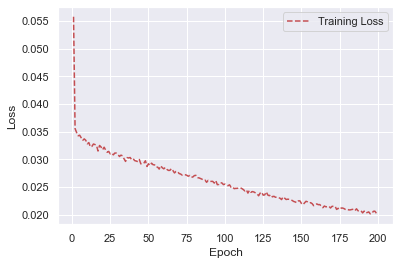

In [69]:
training_loss = modelo_1.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Efectivamente podemos ver que el modelo ha aprendido a medida que aumentaban las épocas.


In [70]:
import math 
train_score = model.evaluate(X_train_nn, y_train_scaled, verbose=0)
print('Puntuacion de entrenamiento: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = model.evaluate(X_test_nn, y_test_scaled, verbose=0)
print('Puntuacion del test: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

Puntuacion de entrenamiento: 0.02 MSE (0.15 RMSE)
Puntuacion del test: 0.12 MSE (0.34 RMSE)


Para obtener las predicciones reales, debido a que los datos se encuentran escalados entre -1 y 1, se debe hacer la transformada inversa utilizando inverse_transform.

Esto se hace para train y test

In [71]:
y_train_pred=model.predict(X_train_nn)
y_test_pred=model.predict(X_test_nn)

actual_predictions_train = scaler.inverse_transform(np.array(y_train_pred).reshape(-1, 1))
real_train = scaler.inverse_transform(np.array(y_train_scaled).reshape(-1, 1))

actual_predictions_test = scaler.inverse_transform(np.array(y_test_pred).reshape(-1, 1))
real_test = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))

Se calcula el RMSE y R2_score

In [72]:
RMSE_train=np.sqrt(mean_squared_error(real_train,actual_predictions_train))
RMSE_test=np.sqrt(mean_squared_error(real_test,actual_predictions_test))
print("RMSE train single: :{:.2f}".format(RMSE_train))
print("RMSE test single: :{:.2f}".format(RMSE_test))

r2_score_train=r2_score(real_train,actual_predictions_train)
r2_score_test=r2_score(real_test,actual_predictions_test)
print("R2 score train single: {:.2f}".format(r2_score_train))
print("R2 score test single: {:.2f}".format(r2_score_test))

RMSE train single: :1665.80
RMSE test single: :3882.73
R2 score train single: 0.81
R2 score test single: 0.12


In [73]:
actual_predictions_train.shape

(1309, 1)

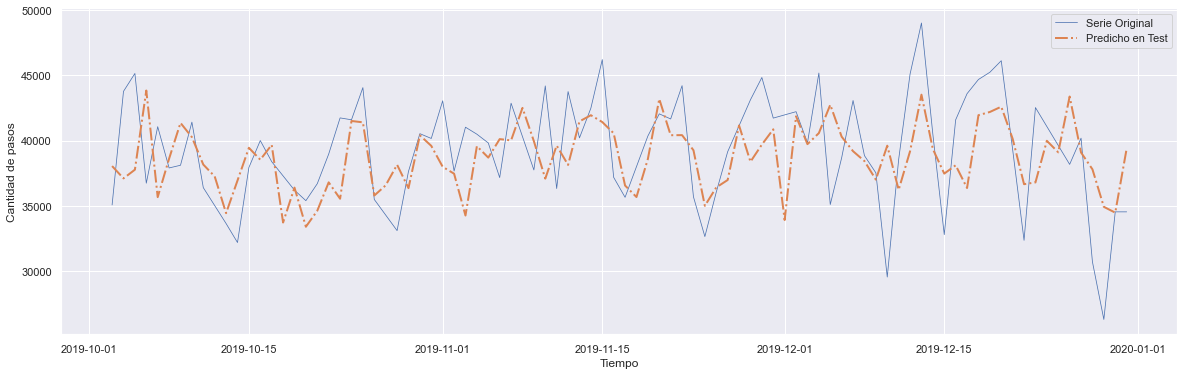

In [74]:
plt.figure(figsize=(20,6))
plt.plot(senial.index[-N_test:], senial[-N_test:],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[-N_test:], actual_predictions_test,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


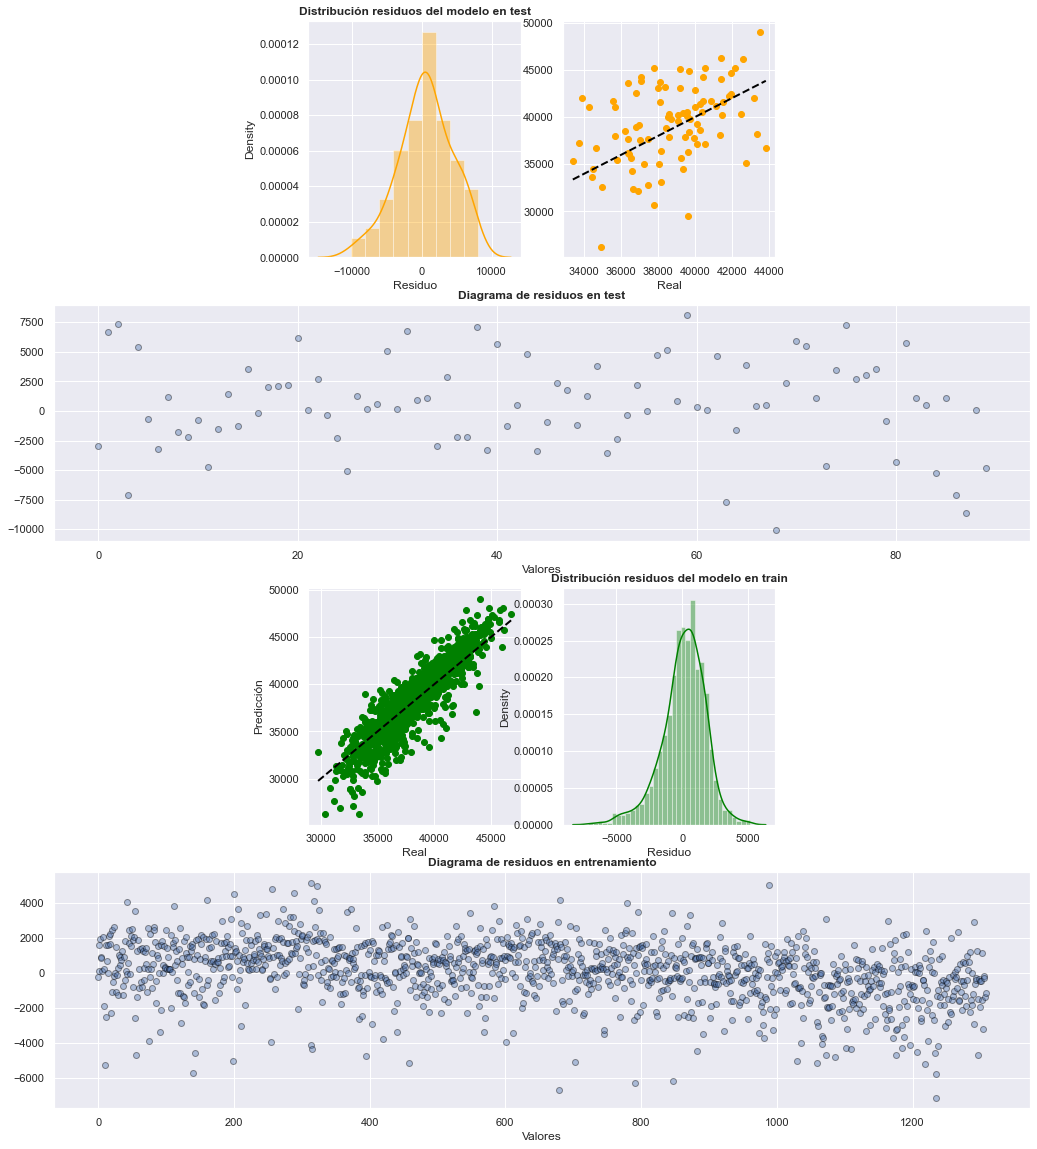

In [75]:
graficas_modelo(real_test,actual_predictions_test,real_train,actual_predictions_train)

In [ ]:
senial.index[-N_test+-2:]

In [ ]:
test_data[28:]

In [ ]:
tensorflow.random.set_seed(2)

visible = Input(shape=(28))
hidden1 = Dense(50, activation='relu')(visible)
output = Dense(1)(hidden1)
model = Model(inputs=visible, outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history=model.fit(X_train_normalized, X_train_normalized, validation_data=(X_test_normalized, y_test_normalized),epochs=100, batch_size=4, verbose=2)

In [ ]:
# Estimacion del rendimiento del modelo

import math 
train_score = model.evaluate(X_train_single, y_train_single, verbose=0)
print('Puntuacion de entrenamiento: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = model.evaluate(X_test_single, y_test_single, verbose=0)
print('Puntuacion del test: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

In [ ]:
y_train_pred=model.predict(X_train_single)
y_test_pred=model.predict(X_test_single)

In [ ]:
RMSE_train=np.sqrt(mean_squared_error(y_train_single,y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test_single,y_test_pred))
print("RMSE train single: :{:.2f}".format(RMSE_train))
print("RMSE test single: :{:.2f}".format(RMSE_test))
r2_score_train=r2_score(y_train_single,y_train_pred)
r2_score_test=r2_score(y_test_single,y_test_pred)
print("R2 score train single: {:.2f}".format(r2_score_train))
print("R2 score test single: {:.2f}".format(r2_score_test))

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [ ]:
graficas_modelo(y_test_single.reshape(-1,1),y_test_pred.reshape(-1,1),y_train_single.reshape(-1,1),y_train_pred.reshape(-1,1))